In [108]:
import scipy
from numpy import *
from matplotlib.pyplot import *
from scipy import integrate
from scipy.sparse import diags
from scipy.sparse.linalg import eigs

In [181]:
# Constantes físicas
hb, m, c, kb, alpha, q = (6.582119569e-16, 510998.950, 299792458,
                          8.617333262e-5, 1/137, 1.602176634e-19)
k, epsilon, kbT = (((hb*c)**2)/(2*m), 55.26349406e6*q**2, kb*30)

# Parâmetros do sistema
dens_dop, xR, m_c, Vcond, N, zf, w, f_in = 2e18*1e6, 0.2, 0.067, 0.170, 1001, 400e-10, 100e-10, 0.05
z, dz = linspace(0,zf,N), zf/(N-1)
zgrid = z*1e10

# Potencial condução, razão química, constante dielétrica, massa efetiva
x = zeros(N)
x[z< zf/2-w/2], x[z > zf/2+w/2]= xR, xR
Vc, diel, mz, Rho_dop = Vcond*x/xR, 12.90-2.84*x, 0.067 + 0.083*x, dens_dop*(xR-x)/xR
mz, diel = insert(mz,0,mz[0]), insert(diel,0,diel[0])
mz, diel = append(mz,mz[-1]), append(diel,diel[-1])
V  = copy(Vc)

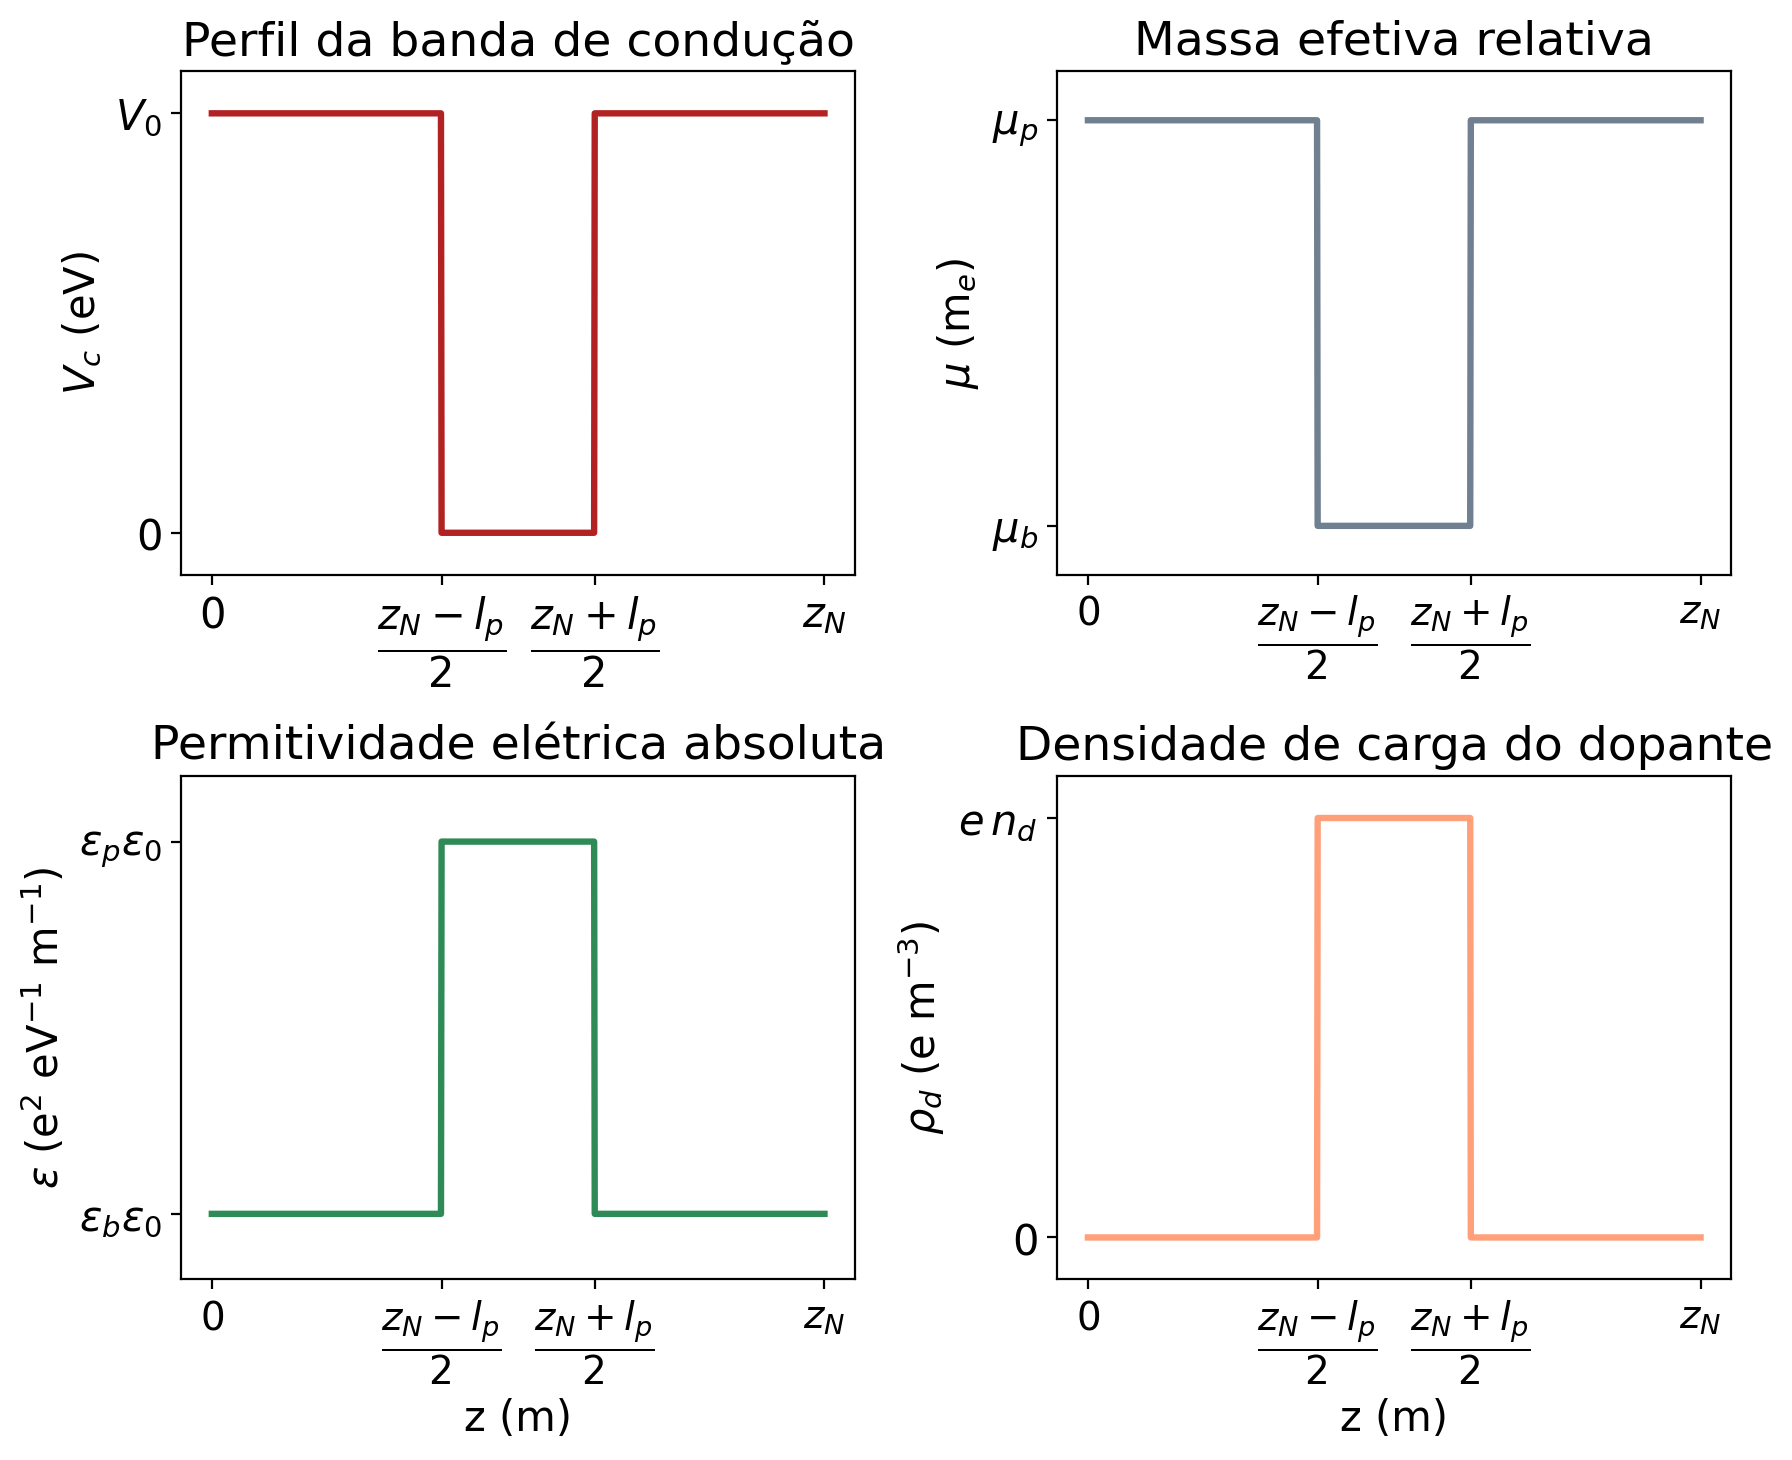

In [200]:
f, axs = subplots(2, 2,figsize=(10,8))
# Figura 1 - Perfil da banda de condução
axs[0,0].set_title('Perfil da banda de condução',fontsize=17)
axs[0,0].plot(z,Vc,color='firebrick',lw= 2.3)
axs[0,0].set_ylim(-max(Vc)*0.1,max(Vc)*1.1)
axs[0,0].set_ylabel(r'$V_c$ (eV)',fontsize=15)
axs[0,0].set_xticks([0,zf/2-w/2,zf/2+w/2,zf],[r'$0$',r'$\dfrac{z_N-l_p}{2}$',r'$\dfrac{z_N+l_p}{2}$',r'$z_N$'],fontsize=15)
axs[0,0].set_yticks([max(Vc), min(Vc)], [r'$V_0$', r'$0$'],fontsize=15)
# Figura 2 - Permitividade elétrica
axs[1,0].set_title('Permitividade elétrica absoluta',fontsize=17)
axs[1,0].plot(z,diel[1:-1],color='seagreen',lw= 2.3)
axs[1,0].set_ylim(min(diel)-0.1, max(diel)+0.1)
axs[1,0].set_xlabel('z (m)',fontsize=15)
axs[1,0].set_ylabel(r'$\varepsilon$ (e$^2$ eV$^{-1}$ m$^{-1}$)',fontsize=15)
axs[1,0].set_xticks([0,zf/2-w/2,zf/2+w/2,zf],[r'$0$',r'$\dfrac{z_N-l_p}{2}$',r'$\dfrac{z_N+l_p}{2}$',r'$z_N$'],fontsize=14)
axs[1,0].set_yticks([min(diel), max(diel)], [r'$\varepsilon_b\varepsilon_0$', r'$\varepsilon_p\varepsilon_0$'],fontsize=15)
# Figura 3 - Massa efetiva
axs[0,1].set_title('Massa efetiva relativa',fontsize=17)
axs[0,1].plot(z,mz[1:-1],color='slategray',lw= 2.3)
axs[0,1].set_ylim(min(mz)-0.002, max(mz)+0.002)
axs[0,1].set_ylabel(r'$\mu$ (m$_e$)',fontsize=15)
axs[0,1].set_xticks([0,zf/2-w/2,zf/2+w/2,zf],[r'$0$',r'$\dfrac{z_N-l_p}{2}$',r'$\dfrac{z_N+l_p}{2}$',r'$z_N$'],fontsize=14)
axs[0,1].set_yticks([min(mz), max(mz)], [r'$\mu_b$', r'$\mu_p$'],fontsize=15)
# Figura 3 - Distribuição da densidade de carga de dopante
axs[1,1].set_title('Densidade de carga do dopante',fontsize=17)
axs[1,1].plot(z,Rho_dop,color='lightsalmon',lw= 2.3)
axs[1,1].set_ylim(-max(Rho_dop)*0.1, max(Rho_dop)*1.1)
axs[1,1].set_xlabel('z (m)',fontsize=15)
axs[1,1].set_ylabel(r'$\rho_d$ (e m$^{-3}$)',fontsize=15)
axs[1,1].set_xticks([0,zf/2-w/2,zf/2+w/2,zf],[r'$0$',r'$\dfrac{z_N-l_p}{2}$',r'$\dfrac{z_N+l_p}{2}$',r'$z_N$'],fontsize=14)
axs[1,1].set_yticks([0, max(Rho_dop)], [r'$0$', r'$e\,n_d$'],fontsize=15)
# Parâmetros gerais
rcParams['figure.dpi']=200
subplots_adjust(hspace=0.4,wspace=0.3)
savefig("30 Parâmetros.png")

In [21]:
def hamiltoniano(V_total):
    H1, H2 = V_total + (k/dz**2)*(1/mz[1:N+1] + 1/mz[0:N]), -(k/dz**2)*(1/mz[1:N])
    hamil = diags([H2, H1, H2], [1, 0, -1], shape=(N, N)).toarray()
    energy, state = linalg.eigh(hamil)
    energia_lgd = copy(energy[energy - max(V_total)<0])
    for i in range(len(energia_lgd)):
        state[:,i] /= integrate.simpson(abs(state[:,i])**2,z)**(1/2)
    return energia_lgd, state

def densidade_eletronica(EF,ener,est):
    dens = 0
    for i in range(len(ener)):
        dens += ((kbT*m_c)/(2*pi*k))*log(1+exp((EF-ener[i])/kbT))*abs(est[:,i])**2
    return dens

def compare(EF,ener,est):
    return integrate.simpson(densidade_eletronica(EF,ener,est),z)-w*dens_dop

def EF_bissec(mini,maxi,par,ener,est):
    var, conv = (mini+maxi)/2, 0
    while abs(compare(var,ener,est))>par:
            if compare(mini,ener,est)*compare(var,ener,est)>0:
                mini = var
            else:
                maxi = var
            var = (mini+maxi)/2
            conv += 1
            if conv == 20:
                break
    return var

def poisson(EF,ener,est):
    dens = q*copy(Rho_dop-densidade_eletronica(EF,ener,est))
    K = (dz**2)*dens/epsilon
    Mei, M1 = -(diel[0:N]+diel[1:N+1]), diel[1:N]
    Mei[-1] += diel[-1]
    Mei[0]  += diel[0]
    M  = diags([M1, Mei, M1], [-1, 0, 1], shape=(N, N)).toarray()
    Vn, trash = scipy.sparse.linalg.cg(M, K)
    return dens, q*Vn

In [202]:
print(densidade_eletronica(0.03,energias,estados))

[1.18645781e+10 4.74950504e+10 1.07001744e+11 ... 1.13692604e+11
 5.04649471e+10 1.26064800e+10]


In [22]:
itera, X = 1, 10
EF, VT, NN, EG = [], [], [], []
# while X > 1e-4:
for i in range(10):
    # Equação de Schrödinger, Estados ligados, Normalização
    energias, estados = hamiltoniano(V)

    # Energia de fermi
    energia_fermi = EF_bissec(-0.3,0.3,1e-6,energias,estados)
    
    # Potencial Poisson, densidades
    V_in = copy(V)
    dens_total, Vn = poisson(energia_fermi,energias,estados)
    V_out = copy(Vc+Vn)
    
    # Resultados
    V = copy(V_in + f_in*(V_out-V_in))
    X = sum((V-V_in)**2/Vcond**2)
    EF.append(energia_fermi), VT.append(copy(Vn)), EG.append(energias[0])
    NN.append(compare(energia_fermi,energias,estados))
    
    # Print de iterações
    print("Iteração ",itera, " X² ", X)
    itera += 1

Iteração  1  X²  0.00012126792265222078
Iteração  2  X²  0.00010845411303522264
Iteração  3  X²  9.695560417056126e-05
Iteração  4  X²  8.670128814389024e-05
Iteração  5  X²  7.752999489898113e-05
Iteração  6  X²  6.93092332165353e-05
Iteração  7  X²  6.196186129140419e-05
Iteração  8  X²  5.541113979320555e-05
Iteração  9  X²  4.9523951656319144e-05
Iteração  10  X²  4.428445041645405e-05


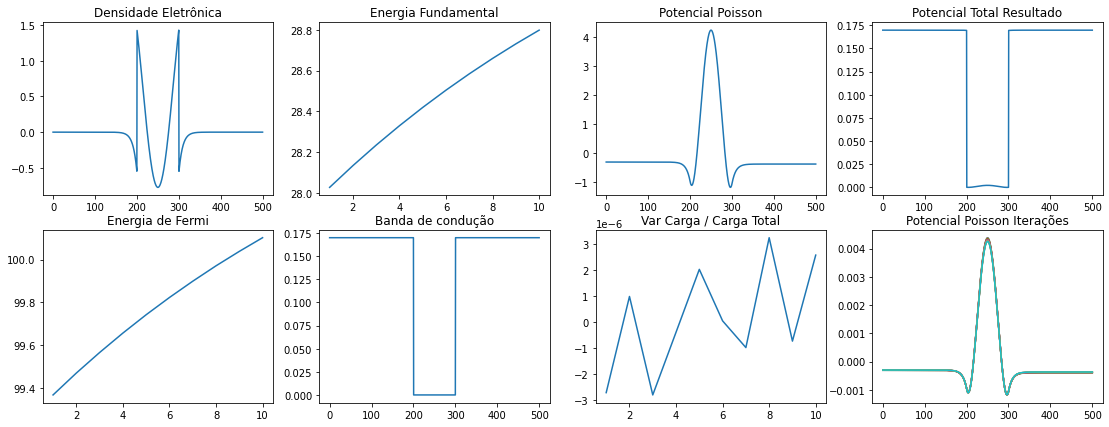

In [23]:
VT, EF, EG, NN, grid = array(VT), array(EF), array(EG), array(NN), linspace(1,itera-1,itera-1)
f, axs = subplots(2, 4, figsize=(19,7))
axs[0,0].set_title('Densidade Eletrônica'), axs[0,0].plot(zgrid,dens_total/(1e18*q*1e6))
axs[0,1].set_title('Energia Fundamental'), axs[0,1].plot(grid,EG*1000)
axs[0,2].set_title('Potencial Poisson'), axs[0,2].plot(zgrid,Vn*1000)
axs[0,3].set_title('Potencial Total Resultado'), axs[0,3].plot(zgrid,V)
axs[1,0].set_title('Energia de Fermi'), axs[1,0].plot(grid, EF*1000)
axs[1,1].set_title('Banda de condução'), axs[1,1].plot(zgrid,Vc)
axs[1,2].set_title('Var Carga / Carga Total'), axs[1,2].plot(grid, NN/(w*dens_dop))
axs[1,3].set_title('Potencial Poisson Iterações')
for i in range(len(VT[:,0])):
    axs[1,3].plot(zgrid,VT[i,:])
f.savefig('30 Dentro WWD.png', dpi=300)